## Metrics (Training Results)

- This notebook shows the training results of different models, including CNN and Particle Transformer.
- Most of the training results are repeated 10 times with different random seeds.
- The signal and background were set to be Higgs from VBF and GGF, respectively.

In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns

sns.set_theme()

# Define the root of the project
ROOT = Path.cwd().parent

def get_metrics(channel: str, data_mode: str, date_time: str, data_suffix: str = '', num_rnd: int = None):
    """Print summary metrics for different models under given configuration."""

    # Define path to metrics output
    output_dir = ROOT / 'output'

    # Loop through models
    df = pd.DataFrame()
    for model in ['CNN_EventCNN', 'ParT_Light']:

        # Collect metrics from each random seed run
        rnd_seed = 123

        for _ in range(num_rnd):
            metrics_file = Path(channel) / data_mode / f"{model}-{date_time}-{data_suffix}" / f'rnd_seed-{rnd_seed}' / 'metrics.csv'
            if not (output_dir / metrics_file).exists():
                print(f"Warning: Metrics file {metrics_file} does not exist. Stopping further checks for this model.")
                break

            df_tmp = pd.read_csv(output_dir / metrics_file)
            test_metrics = df_tmp.tail(1)
            df = pd.concat([df, pd.DataFrame({
                'model': model,
                'rnd_seed': rnd_seed,
                'test_accuracy': test_metrics['test_accuracy'].values,
                'test_auc': test_metrics['test_auc'].values,
                'epoch': test_metrics['epoch'].values
            })], ignore_index=True)

            rnd_seed += 100

    return df

## $H \rightarrow \gamma \gamma$

#### Keras-like settings

- 20251001_052410
- Keras parameter initialization
- Keras batch normalizaiton in CNN

#### PyTorch default settings

- `float32`
- 20250930_105915 : +0
- 20250923_232355 : +5
- 20250924_111848 : +10

In [ ]:
df = pd.DataFrame()
date_time_list = ['20250930_105915', '20250923_232355', '20250924_111848']
for data_mode, channel, date_time in product(['jet_flavor'], ['diphoton', 'ex-diphoton'], date_time_list):
    for luminosity in [100, 300, 900, 1800, 3000]:
        tmp_df = get_metrics(channel=channel, data_mode=data_mode, date_time=date_time, data_suffix=f'L{luminosity}', num_rnd=10)
        tmp_df['channel'] = channel
        tmp_df['data_mode'] = data_mode
        tmp_df['date_time'] = date_time
        tmp_df['luminosity'] = luminosity
        df = pd.concat([df, tmp_df], ignore_index=True)

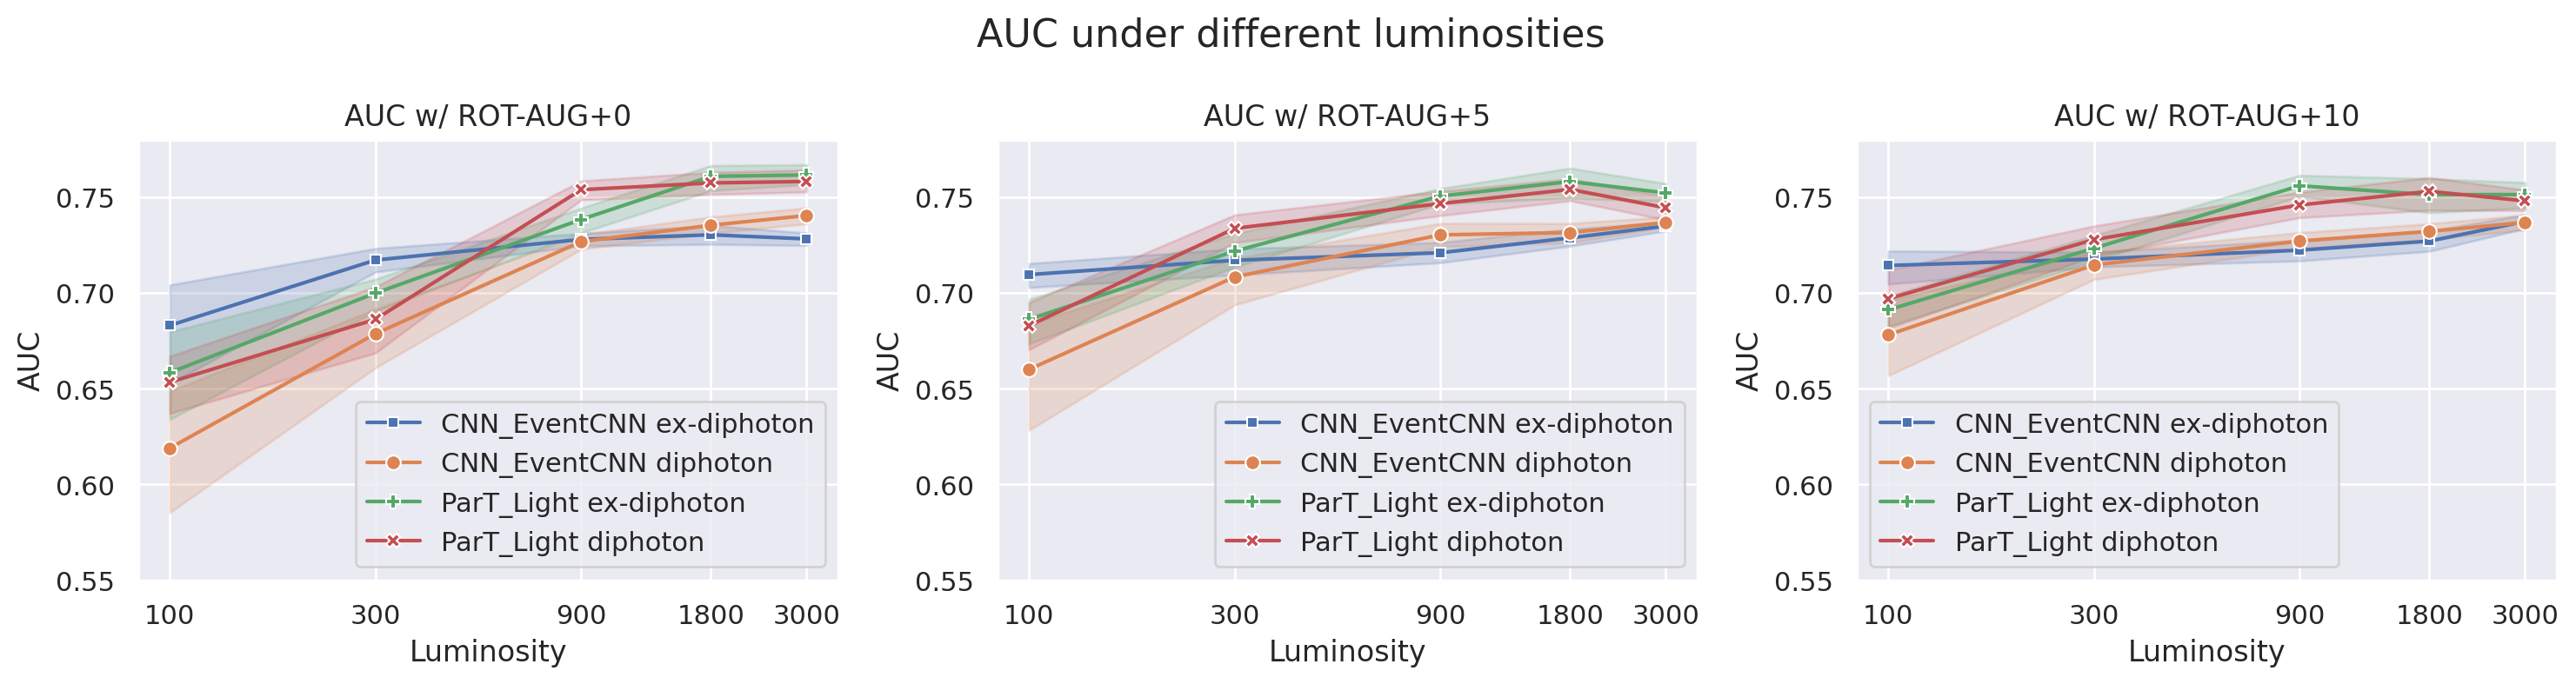

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=200)
fig.suptitle(f"AUC under different luminosities", fontsize=16)
plt_title_list = ['+0', '+5', '+10']

# Add combined model-channel column for hue
df["model_channel"] = df["model"] + " " + df["channel"]
hue_order = ['CNN_EventCNN ex-diphoton', 'CNN_EventCNN diphoton', 'ParT_Light ex-diphoton', 'ParT_Light diphoton']

for i, date_time in enumerate(date_time_list):
    tmp_df = df[df['date_time'] == date_time]
    sns.lineplot(data=tmp_df, x='luminosity', y='test_auc', hue='model_channel', hue_order=hue_order, style='model_channel', markers=True, dashes=False, ax=ax[i])
    ax[i].set_title(f"AUC w/ ROT-AUG{plt_title_list[i]}")
    ax[i].set_xscale("log")
    ax[i].set_xticks([100, 300, 900, 1800, 3000])
    ax[i].set_xticklabels([100, 300, 900, 1800, 3000])
    ax[i].set_ylim(0.55, 0.78)
    ax[i].set(xlabel="Luminosity", ylabel="AUC")
    ax[i].legend()

plt.tight_layout()
plt.show()

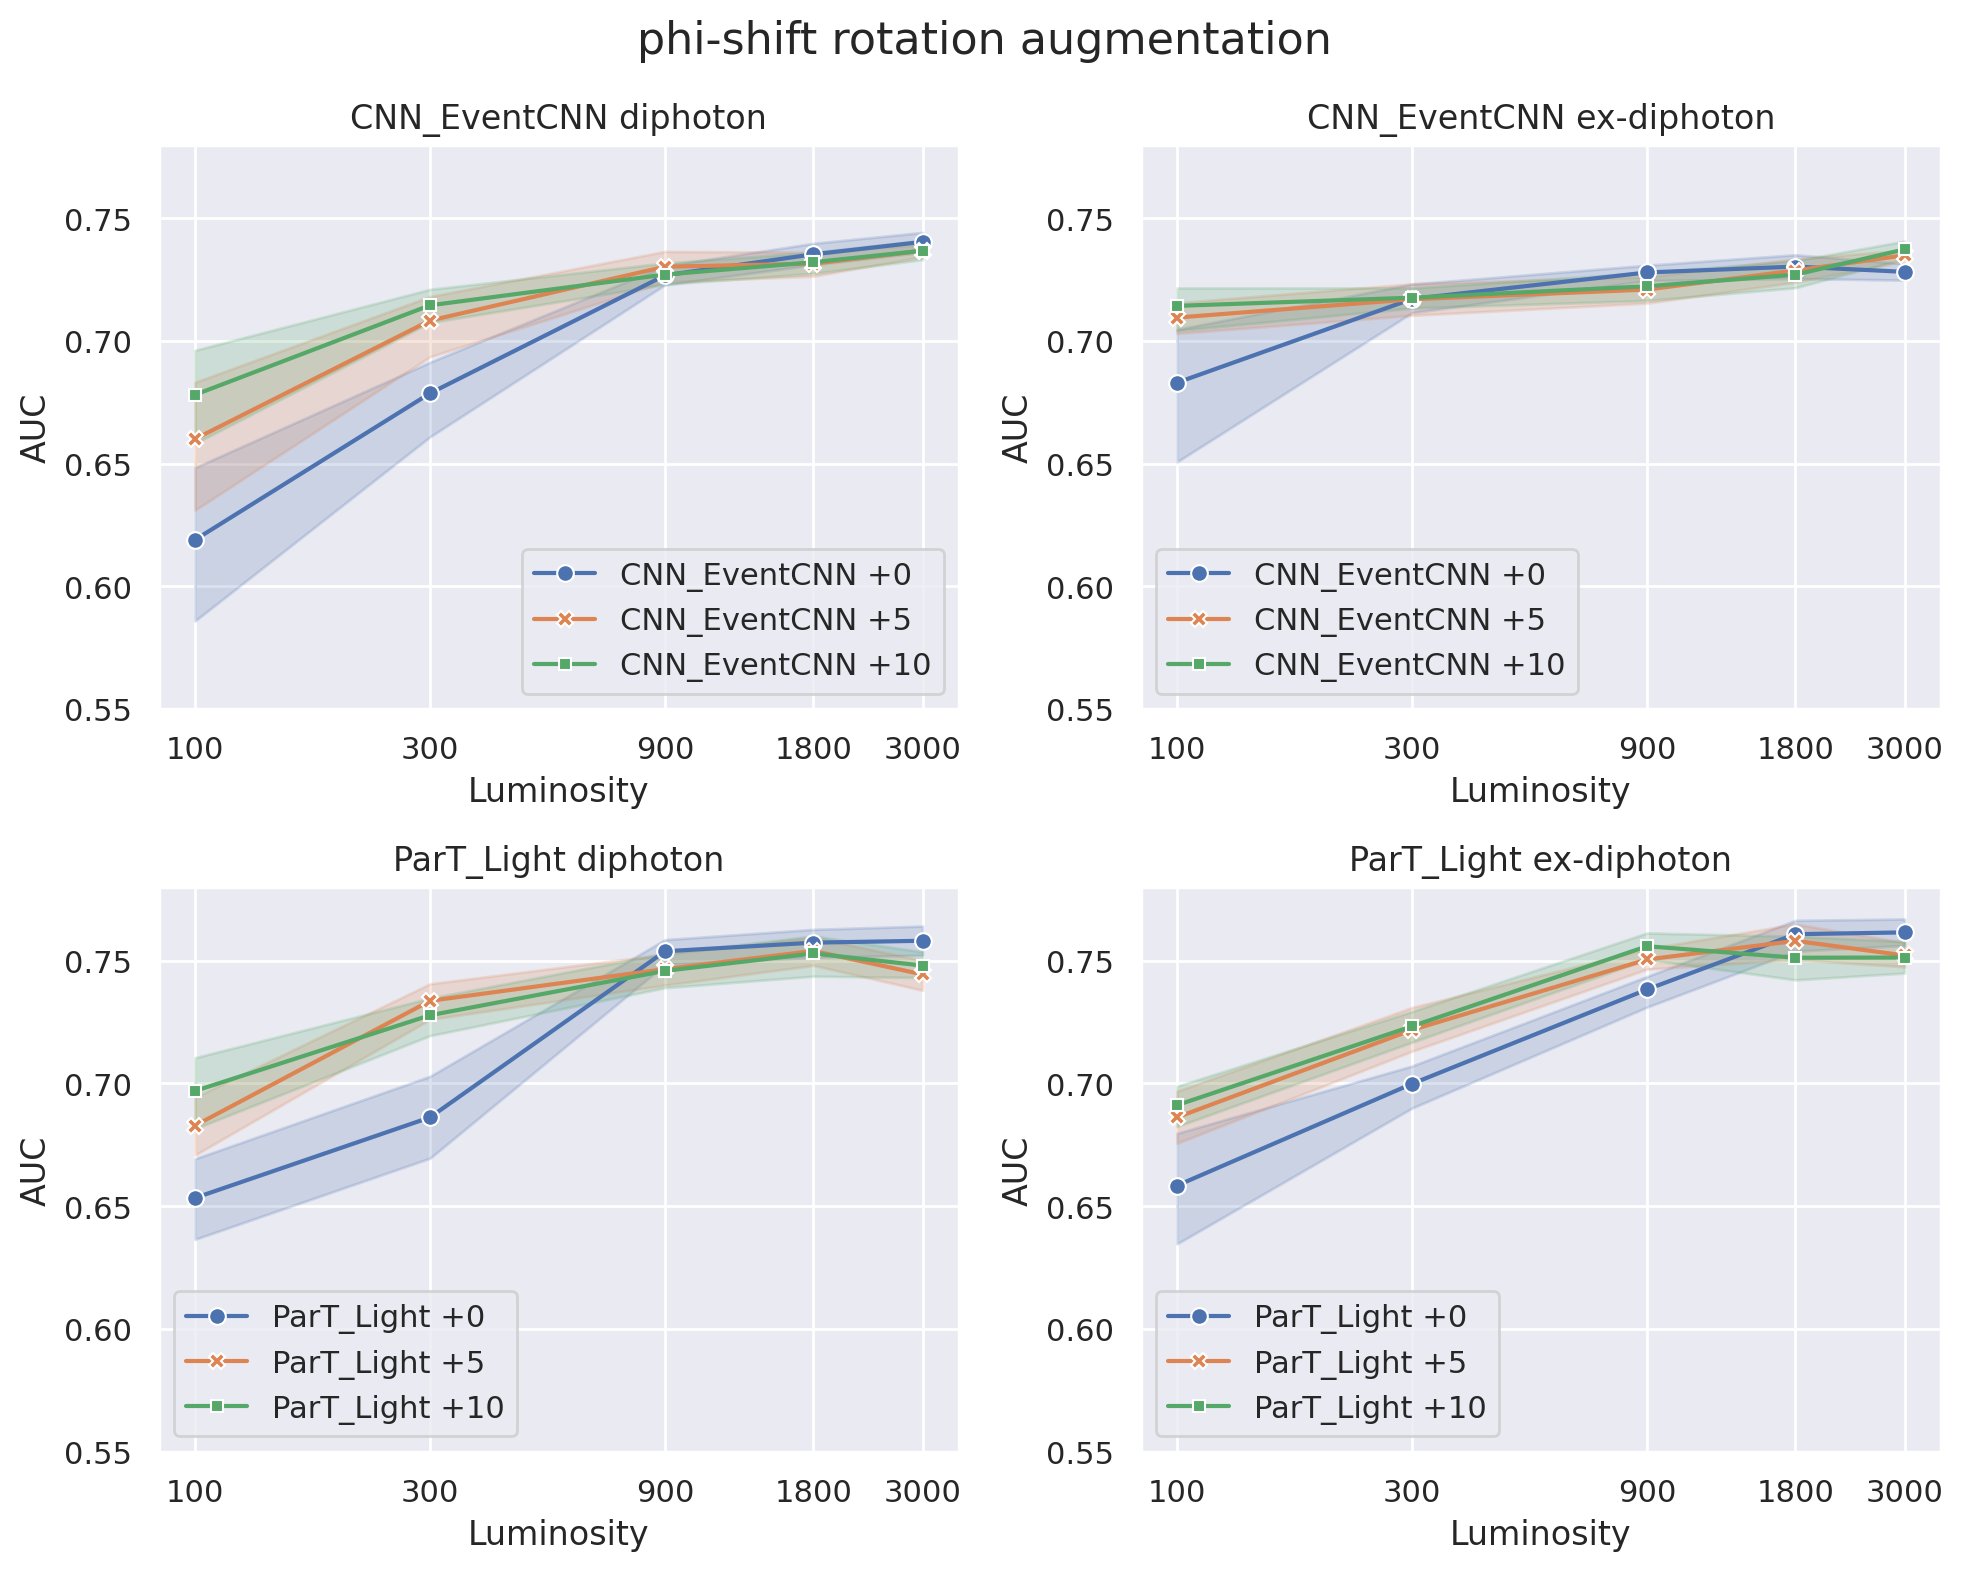

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), dpi=200)
fig.suptitle(f"phi-shift rotation augmentation", fontsize=16)

# Add information about date time
df.loc[df['date_time'] == '20250930_105915', 'num_rot_augmentation'] = '+0'
df.loc[df['date_time'] == '20250923_232355', 'num_rot_augmentation'] = '+5'
df.loc[df['date_time'] == '20250924_111848', 'num_rot_augmentation'] = '+10'

# Add combined model-channel column for hue
df["model_rot_aug"] = df["model"] + " " + df["num_rot_augmentation"]

for i, model in enumerate(['CNN_EventCNN', 'ParT_Light']):
    for j, channel in enumerate(['diphoton', 'ex-diphoton']):
        tmp_df = df[(df['model'] == model) & (df['channel'] == channel)]
        sns.lineplot(data=tmp_df, x='luminosity', y='test_auc', hue='model_rot_aug', style='model_rot_aug', markers=True, dashes=False, ax=ax[i, j])
        ax[i, j].set_title(f"{model} {channel}")
        ax[i, j].set_xscale("log")
        ax[i, j].set_xticks([100, 300, 900, 1800, 3000])
        ax[i, j].set_xticklabels([100, 300, 900, 1800, 3000])
        ax[i, j].set_ylim(0.55, 0.78)
        ax[i, j].set(xlabel="Luminosity", ylabel="AUC")
        ax[i, j].legend()

plt.tight_layout()
plt.show()

## $H \rightarrow \gamma \gamma$ apply to $H \rightarrow ZZ \rightarrow 4l$

- The inference used data and trained models that **WITHOUT** decay products.

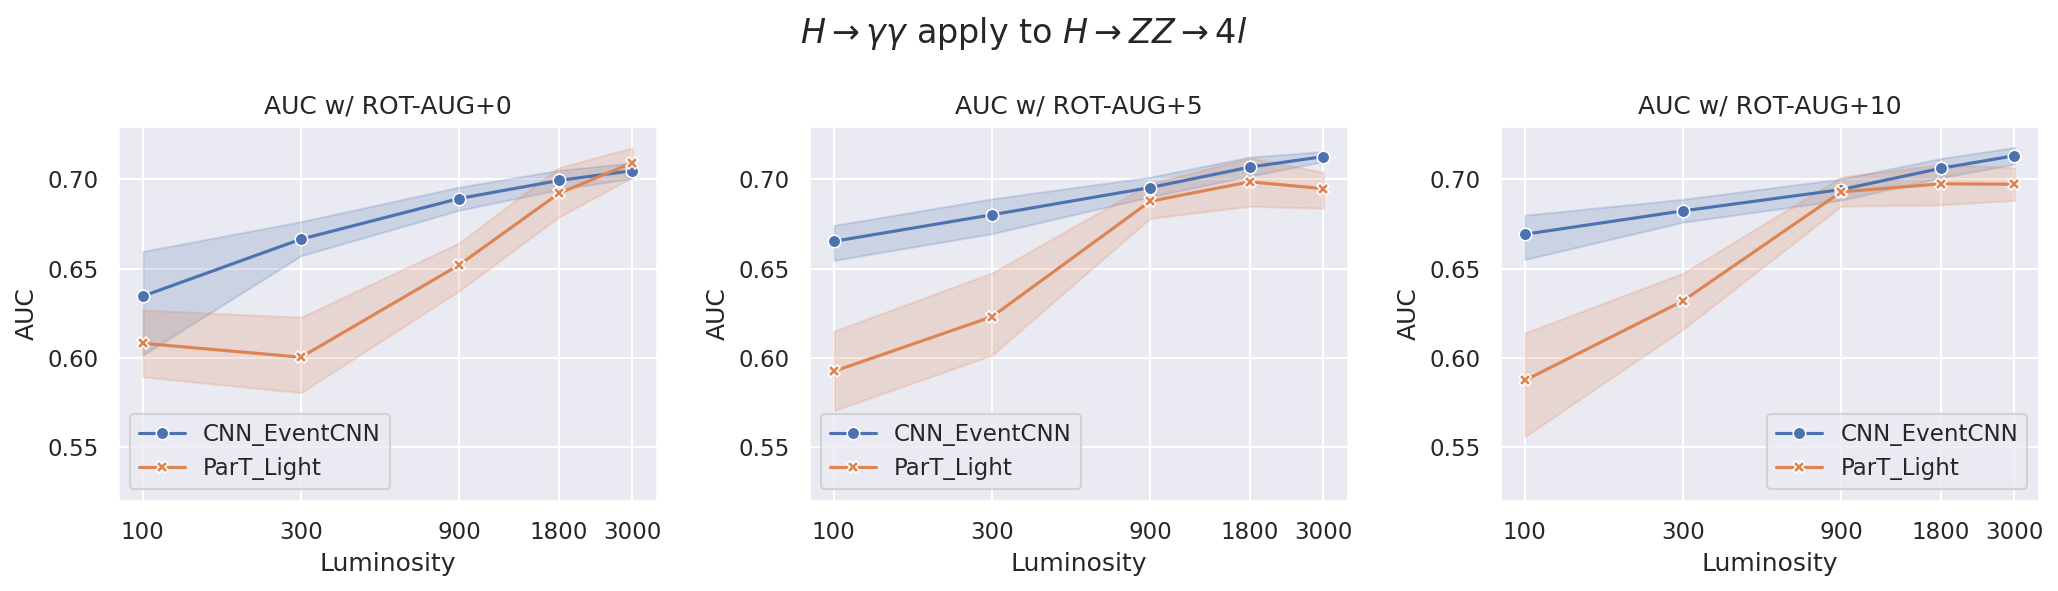

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), dpi=150)
fig.suptitle(r"$H\rightarrow\gamma\gamma$ apply to $H\rightarrow ZZ\rightarrow 4l$", fontsize=16)
plt_title_list = ['+0', '+5', '+10']

for i, date_time in enumerate(['20250930_105915', '20250923_232355', '20250924_111848']):
    df = pd.read_csv(ROOT / 'output' / 'inference' / f'inference_{date_time}.csv')

    sns.lineplot(data=df, x='luminosity', y='test_auc', hue='model_name', style='model_name', markers=True, dashes=False, ax=ax[i])
    ax[i].set_xscale("log")
    ax[i].set_xticks([100, 300, 900, 1800, 3000])
    ax[i].set_xticklabels([100, 300, 900, 1800, 3000])
    ax[i].set(xlabel="Luminosity", ylabel="AUC")
    ax[i].set_title(f"AUC w/ ROT-AUG{plt_title_list[i]}")
    ax[i].set_ylim(0.52, 0.73)
    ax[i].legend()

plt.tight_layout()
plt.show()